In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

Populating the interactive namespace from numpy and matplotlib


In [16]:
results = pd.read_csv('BC_final_results.csv', index_col=0).query('g != "log_total_count"')
ms_results = pd.read_csv('BC_MS_results.csv', index_col=0).query('g != "log_total_count"')
sample_info = pd.read_csv('BC_sample_info.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)
ms_results['pval'] = ms_results['pval'].clip_lower(ms_results.query('pval > 0')['pval'].min() / 2)
ms_results['qval'] = ms_results['qval'].clip_lower(ms_results.query('qval > 0')['qval'].min() / 2)

In [17]:
df = pd.read_table('data/Layer2_BC_count_matrix-1.tsv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

df = df[results.g]  # Order like in results

dfm = np.log10(df + 1)

In [18]:
def xpercent_scale():
    gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in gca().get_xticks()])

In [19]:
from matplotlib.colors import LogNorm

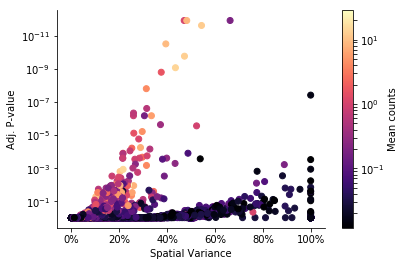

In [20]:
plt.yscale('log')
plt.scatter(results.FSV, results.qval,
            c=df.mean(),
            norm=LogNorm(),
            cmap=cm.magma,
            rasterized=True);

plt.gca().invert_yaxis();

xpercent_scale()
plt.xlabel('Spatial Variance')
plt.ylabel('Adj. P-value');
plt.colorbar(label='Mean counts');

plt.savefig('significane-mean-counts.pdf')

In [21]:
# Calculate alternative features

results['nmean'] = df.mean()[results.g].values
results['nvar'] = df.var()[results.g].values
results['cv2'] = ((df.std() / df.mean()) ** 2)[results.g].values
results['gvar'] = dfm.var()[results.g].values
results['fracdrop'] = (1 - (df > 1).sum() / df.shape[0])[results.g].values

In [22]:
dfm.shape

(250, 12856)

In [23]:
results.shape

(12856, 23)

In [179]:
def feature_qval(results, feature, xlog=True, sel_genes=None, random_genes=0):
    if xlog:
        plt.xscale('log')

    plt.yscale('log')
    plt.scatter(results[feature], results.qval, c='k', rasterized=True);
    
    tmp = results.query('qval < 0.05')
    plt.scatter(tmp[feature], tmp.qval, c='grey');
    
    if sel_genes:
        tmp = results.query('g in @sel_genes')
        for _, g in tmp.iterrows():
            plt.annotate(g.g, (g[feature], g.qval), color='red')
            
    if random_genes:
        tmp = results.query('qval < 0.05').sample(random_genes)
        for _, g in tmp.iterrows():
            plt.annotate(g.g, (g[feature], g.qval), color='red')
    
    plt.gca().invert_yaxis();
    
    plt.axhline(0.05, c='k', ls='--', lw=1);
    
    plt.ylabel('SpatialDE Adj. P-value');

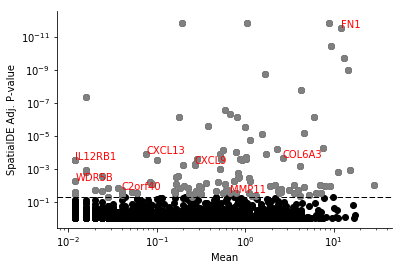

In [182]:
feature_qval(results, 'nmean', sel_genes=['CXCL9', 'CXCL13', 'IL12RB1'], random_genes=5)
plt.xlabel('Mean');
plt.savefig('mean-pval.pdf')

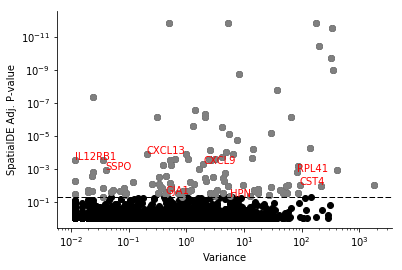

In [183]:
feature_qval(results, 'nvar', sel_genes=['CXCL9', 'CXCL13', 'IL12RB1'], random_genes=5)
plt.xlabel('Variance');
plt.savefig('var-pval.pdf')

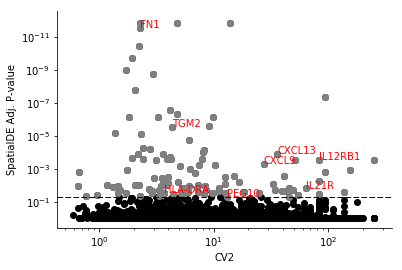

In [184]:
feature_qval(results, 'cv2', sel_genes=['CXCL9', 'CXCL13', 'IL12RB1'], random_genes=5)
plt.xlabel('CV2');
plt.savefig('cv2-pval.pdf')

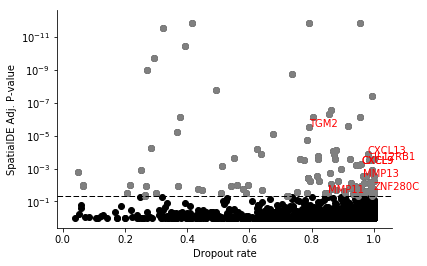

In [186]:
feature_qval(results, 'fracdrop', xlog=False, sel_genes=['CXCL9', 'CXCL13', 'IL12RB1'], random_genes=5)
plt.xlabel('Dropout rate');
plt.savefig('dr-pval.pdf')

In [187]:
def feature_pairs(results, feature1, feature2, ylog=True, sel_genes=None, random_genes=0):
    plt.xscale('log')
    if ylog:
        plt.yscale('log')

    plt.scatter(results[feature1], results[feature2], c='k', rasterized=True);
    
    tmp = results.query('qval < 0.05')
    plt.scatter(tmp[feature1], tmp[feature2], c='grey');
    
    if sel_genes:
        tmp = results.query('g in @sel_genes')
        for _, g in tmp.iterrows():
            plt.annotate(g.g, (g[feature1], g[feature2]), color='red')
            
    if random_genes:
        tmp = results.query('qval < 0.05').sample(random_genes)
        for _, g in tmp.iterrows():
            plt.annotate(g.g, (g[feature1], g[feature2]), color='red')

In [191]:
from scipy import optimize

In [192]:
quadratic = lambda mu, a, b, c: a + b * mu + c * mu ** 2

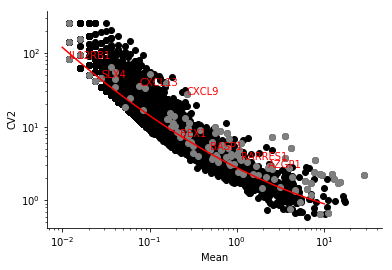

In [235]:
params, _ = optimize.curve_fit(quadratic, np.log10(results.nmean), np.log10(results.cv2))

xx = np.linspace(-2, 1)
x = 10 ** xx
yy = quadratic(xx, *params)
y = 10 ** yy

feature_pairs(results, 'nmean', 'cv2', sel_genes=['CXCL9', 'CXCL13', 'IL12RB1'], random_genes=5)
plt.plot(x, y, c='r');
plt.xlabel('Mean');
plt.ylabel('CV2');

plt.savefig('mean-cv2.pdf')

In [216]:
results['mvcv2_score'] = hvg_score = np.log10(results.cv2) - quadratic(np.log10(results.nmean), *params)

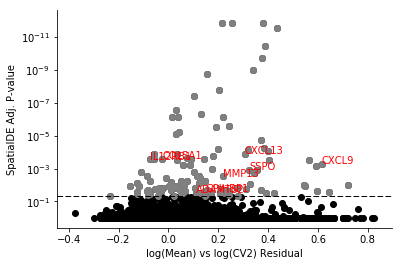

In [236]:
feature_qval(results, 'mvcv2_score', xlog=False, sel_genes=['CXCL9', 'CXCL13', 'IL12RB1'], random_genes=5)
plt.xlabel('log(Mean) vs log(CV2) Residual');

plt.savefig('cv2hvg-pval.pdf')

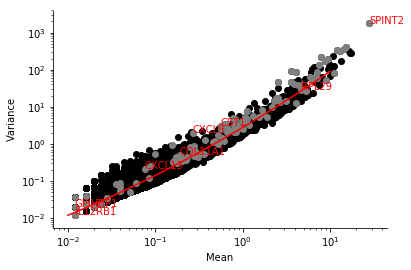

In [237]:
params, _ = optimize.curve_fit(quadratic, np.log10(results.nmean), np.log10(results.nvar))

xx = np.linspace(-2, 1)
x = 10 ** xx
yy = quadratic(xx, *params)
y = 10 ** yy

feature_pairs(results, 'nmean', 'nvar', sel_genes=['CXCL9', 'CXCL13', 'IL12RB1'], random_genes=5)
plt.plot(x, y, c='r');
plt.xlabel('Mean')
plt.ylabel('Variance');

plt.savefig('mean-var.pdf')

In [238]:
results['mvvar_score'] = np.log10(results.nvar) - quadratic(np.log10(results.nmean), *params)

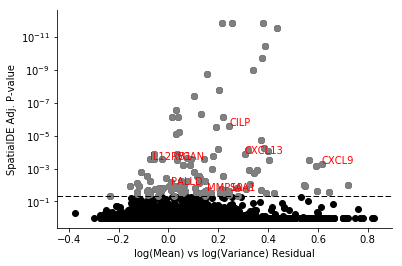

In [239]:
feature_qval(results, 'mvvar_score', xlog=False, sel_genes=['CXCL9', 'CXCL13', 'IL12RB1'], random_genes=5)
plt.xlabel('log(Mean) vs log(Variance) Residual');

plt.savefig('varhvg-pval.pdf')

In [240]:
from scipy.special import expit

In [241]:
logistic = lambda x, a, b: expit(a + b * x)

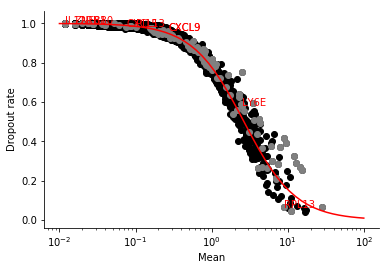

In [243]:
params, _ = optimize.curve_fit(logistic, np.log10(results.nmean), results.fracdrop)

xx = np.linspace(-2, 2)
x = 10 ** xx
yy = logistic(xx, *params)
y = yy

feature_pairs(results, 'nmean', 'fracdrop', ylog=False, sel_genes=['CXCL9', 'CXCL13', 'IL12RB1'], random_genes=5)
plt.plot(x, y, c='r');
plt.xlabel('Mean')
plt.ylabel('Dropout rate');

plt.savefig('mean-dr.pdf')

In [244]:
results['mvfd_score'] = results.fracdrop - logistic(np.log10(results.nmean), *params)

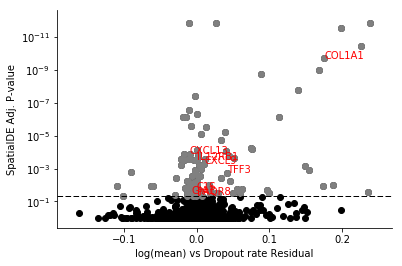

In [248]:
feature_qval(results, 'mvfd_score', xlog=False, sel_genes=['CXCL9', 'CXCL13', 'IL12RB1'], random_genes=5)
plt.xlabel('log(mean) vs Dropout rate Residual');

plt.savefig('drhvg-pval.pdf');